In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from PIL import ImageOps
from src.training import fit
import torchinfo as torchinfo
from src.evaluation import evaluate_model
from collections import Counter
from torchvision import datasets, transforms
from src.training import plot_train_results_from_json
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler

# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path de descarga de datasets usando KaggleHub
os.environ["KAGGLEHUB_CACHE"] = "./"

# PARAMETROS GLOBALES
BATCH_SIZE = 256
WORKERS = 0
DATASET_AUGMENTED_SIZE = 4000

print(f'Dispositivo a utilizar: {device}')

Dispositivo a utilizar: cuda


In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU (si aplica)

    # Determinismo en cuDNN (puede impactar en performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [ ]:
# Directorio raíz del dataset
root_dir = "./data/dataset"

# Inicializamos contador
channel_counter = Counter()
errors = []

# Recorremos todas las imágenes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(root_dir, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    channel_counter[img.mode] += 1
            except Exception as e:
                errors.append((img_path, str(e)))

# Resultados
print("Cantidad de imágenes por tipo de canal (modo):")
for mode, count in channel_counter.items():
    print(f"  {mode}: {count} imágenes")

if errors:
    print("\nErrores al abrir algunas imágenes:")
    for path, err in errors:
        print(f"  {path} -> {err}")

Cantidad de imágenes por tipo de canal (modo):
  RGBA: 923 imágenes
  RGB: 74 imágenes
  L: 3 imágenes


In [6]:
class ResizeWithAspectRatioPadding:
    """
    Clase para redimensionar imágenes manteniendo el aspecto y rellenando con ceros (padding).
    """
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Convertimos a tamaño cuadrado manteniendo aspecto
        old_width, old_height = img.size
        ratio = min(self.target_size[0] / old_width, self.target_size[1] / old_height)
        new_size = (int(old_width * ratio), int(old_height * ratio))
        img = img.resize(new_size, resample=Image.BILINEAR)

        delta_w = self.target_size[0] - new_size[0]
        delta_h = self.target_size[1] - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=0)

        return img

In [7]:
# Paso previo obligatorio: transformar todo a RGB
to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

# Tamaño objetivo (input para ResNet)
image_size = (299, 299)

# 1- Se aplican distintas transformaciones para el dataset de train y test
# Transform para train (con augmentations)
train_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Augmentations suaves
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para valid (sin augmentations, con resize)
valid_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para test (idéntico a valid)
test_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/test', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,num_samples=DATASET_AUGMENTED_SIZE,replacement=True
)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 315


In [8]:
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights)
print(f'La arquitectura por default de ResNet-50 es la siguiente:\n\n{model}') 

La arquitectura por default de ResNet-50 es la siguiente:

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicC

In [9]:
torchinfo.summary(model, input_size=(1, 3, 224, 224), depth=3, col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
Inception3                               --                        [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       --                        [1, 32, 111, 111]         --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 32, 111, 111]         864
│    └─BatchNorm2d: 2-2                  --                        [1, 32, 111, 111]         64
├─BasicConv2d: 1-2                       --                        [1, 32, 109, 109]         --
│    └─Conv2d: 2-3                       [3, 3]                    [1, 32, 109, 109]         9,216
│    └─BatchNorm2d: 2-4                  --                        [1, 32, 109, 109]         64
├─BasicConv2d: 1-3                       --                        [1, 64, 109, 109]         --
│    └─Conv2d: 2-5                       [3, 3]                    [1, 64, 109, 109]         18,432
│    └─BatchNorm2d: 

In [10]:
def build_inceptionv3_transfer(num_classes: int = 4) -> nn.Module:
    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    aux_in_features = model.AuxLogits.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # Congelar todos los parámetros
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar solo la nueva fc
    for param in model.fc.parameters():
        param.requires_grad = True
    for param in model.AuxLogits.fc.parameters():
        param.requires_grad = True

    return model

def build_inceptionv3_finetune(num_classes: int = 4) -> nn.Module:
    model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    aux_in_features = model.AuxLogits.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # Congelar todo menos layer4 y fc
    for name, param in model.named_parameters():
        if any(layer in name for layer in ["Mixed_7", "fc", "AuxLogits"]):
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

In [11]:
model = build_inceptionv3_transfer(num_classes=4)

# Verificación
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")

Entrenando: AuxLogits.fc.weight
Entrenando: AuxLogits.fc.bias
Entrenando: fc.weight
Entrenando: fc.bias


In [12]:
fit(model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/inceptionv3_fc_weights.pth', results_file='data/inceptionv3_fc_train_results.json') 

val_loss 1.19076 val_acc 0.41667: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 1/100 loss 1.62029 val_loss 1.19076 acc 0.47407 val_acc 0.41667 train_f1 0.46770 val_f1 0.39105
Mejor modelo guardado en la época 1 con val_loss 1.19076
Mejor modelo guardado.


val_loss 1.13092 val_acc 0.47222: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 2/100 loss 1.21771 val_loss 1.13092 acc 0.65581 val_acc 0.47222 train_f1 0.64452 val_f1 0.43287
Mejor modelo guardado en la época 2 con val_loss 1.13092
Mejor modelo guardado.


val_loss 1.03543 val_acc 0.52778: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 3/100 loss 1.05806 val_loss 1.03543 acc 0.69551 val_acc 0.52778 train_f1 0.68957 val_f1 0.48610
Mejor modelo guardado en la época 3 con val_loss 1.03543
Mejor modelo guardado.


val_loss 0.92588 val_acc 0.55556: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 4/100 loss 0.94927 val_loss 0.92588 acc 0.72847 val_acc 0.55556 train_f1 0.72401 val_f1 0.54050
Mejor modelo guardado en la época 4 con val_loss 0.92588
Mejor modelo guardado.


val_loss 0.92699 val_acc 0.55556: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 5/100 loss 0.89234 val_loss 0.92699 acc 0.74888 val_acc 0.55556 train_f1 0.74450 val_f1 0.54654


val_loss 0.91224 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 6/100 loss 0.83104 val_loss 0.91224 acc 0.76450 val_acc 0.56944 train_f1 0.76059 val_f1 0.56002
Mejor modelo guardado en la época 6 con val_loss 0.91224
Mejor modelo guardado.


val_loss 0.89301 val_acc 0.56944: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 7/100 loss 0.79191 val_loss 0.89301 acc 0.77495 val_acc 0.56944 train_f1 0.77028 val_f1 0.56938
Mejor modelo guardado en la época 7 con val_loss 0.89301
Mejor modelo guardado.


val_loss 0.89153 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 8/100 loss 0.76057 val_loss 0.89153 acc 0.78721 val_acc 0.59722 train_f1 0.78341 val_f1 0.59306
Mejor modelo guardado en la época 8 con val_loss 0.89153
Mejor modelo guardado.


val_loss 0.88388 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 9/100 loss 0.73360 val_loss 0.88388 acc 0.79072 val_acc 0.61111 train_f1 0.78733 val_f1 0.60726
Mejor modelo guardado en la época 9 con val_loss 0.88388
Mejor modelo guardado.


val_loss 0.86650 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch 10/100 loss 0.71578 val_loss 0.86650 acc 0.78672 val_acc 0.58333 train_f1 0.78415 val_f1 0.58300
Mejor modelo guardado en la época 10 con val_loss 0.86650
Mejor modelo guardado.


val_loss 0.85283 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 11/100 loss 0.69096 val_loss 0.85283 acc 0.79111 val_acc 0.58333 train_f1 0.78867 val_f1 0.57331
Mejor modelo guardado en la época 11 con val_loss 0.85283
Mejor modelo guardado.


val_loss 0.85704 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 12/100 loss 0.68390 val_loss 0.85704 acc 0.79946 val_acc 0.59722 train_f1 0.79830 val_f1 0.59332


val_loss 0.84286 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 13/100 loss 0.66759 val_loss 0.84286 acc 0.79761 val_acc 0.61111 train_f1 0.79422 val_f1 0.60816
Mejor modelo guardado en la época 13 con val_loss 0.84286
Mejor modelo guardado.


val_loss 0.85943 val_acc 0.58333: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 14/100 loss 0.66079 val_loss 0.85943 acc 0.79971 val_acc 0.58333 train_f1 0.79837 val_f1 0.58149


val_loss 0.84392 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 15/100 loss 0.62153 val_loss 0.84392 acc 0.81797 val_acc 0.61111 train_f1 0.81607 val_f1 0.60641


val_loss 0.82753 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 16/100 loss 0.62491 val_loss 0.82753 acc 0.81396 val_acc 0.63889 train_f1 0.81318 val_f1 0.63710
Mejor modelo guardado en la época 16 con val_loss 0.82753
Mejor modelo guardado.


val_loss 0.81912 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 17/100 loss 0.60242 val_loss 0.81912 acc 0.82241 val_acc 0.65278 train_f1 0.82153 val_f1 0.65058
Mejor modelo guardado en la época 17 con val_loss 0.81912
Mejor modelo guardado.


val_loss 0.81618 val_acc 0.59722: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 18/100 loss 0.61900 val_loss 0.81618 acc 0.81724 val_acc 0.59722 train_f1 0.81518 val_f1 0.59547
Mejor modelo guardado en la época 18 con val_loss 0.81618
Mejor modelo guardado.


val_loss 0.83931 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 19/100 loss 0.60194 val_loss 0.83931 acc 0.82090 val_acc 0.61111 train_f1 0.82064 val_f1 0.60967


val_loss 0.80546 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 20/100 loss 0.58441 val_loss 0.80546 acc 0.81895 val_acc 0.65278 train_f1 0.81772 val_f1 0.64937
Mejor modelo guardado en la época 20 con val_loss 0.80546
Mejor modelo guardado.


val_loss 0.81188 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 21/100 loss 0.56587 val_loss 0.81188 acc 0.83291 val_acc 0.61111 train_f1 0.83176 val_f1 0.60792


val_loss 0.80057 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch 22/100 loss 0.55850 val_loss 0.80057 acc 0.82461 val_acc 0.61111 train_f1 0.82389 val_f1 0.61044
Mejor modelo guardado en la época 22 con val_loss 0.80057
Mejor modelo guardado.


val_loss 0.79336 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 23/100 loss 0.54610 val_loss 0.79336 acc 0.83418 val_acc 0.65278 train_f1 0.83362 val_f1 0.65524
Mejor modelo guardado en la época 23 con val_loss 0.79336
Mejor modelo guardado.


val_loss 0.80521 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 24/100 loss 0.55167 val_loss 0.80521 acc 0.82798 val_acc 0.63889 train_f1 0.82627 val_f1 0.63912


val_loss 0.82696 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 25/100 loss 0.54854 val_loss 0.82696 acc 0.83101 val_acc 0.61111 train_f1 0.82986 val_f1 0.60802


val_loss 0.82282 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 26/100 loss 0.55461 val_loss 0.82282 acc 0.82446 val_acc 0.61111 train_f1 0.82314 val_f1 0.60706


val_loss 0.79687 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 27/100 loss 0.52606 val_loss 0.79687 acc 0.83730 val_acc 0.62500 train_f1 0.83570 val_f1 0.62008


val_loss 0.80178 val_acc 0.68056: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 28/100 loss 0.53852 val_loss 0.80178 acc 0.82915 val_acc 0.68056 train_f1 0.82876 val_f1 0.67334


val_loss 0.81603 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Epoch 29/100 loss 0.54794 val_loss 0.81603 acc 0.83032 val_acc 0.61111 train_f1 0.82960 val_f1 0.60727


val_loss 0.80900 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 30/100 loss 0.51992 val_loss 0.80900 acc 0.83149 val_acc 0.63889 train_f1 0.83090 val_f1 0.63280


val_loss 0.79138 val_acc 0.63889: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 31/100 loss 0.52476 val_loss 0.79138 acc 0.83613 val_acc 0.63889 train_f1 0.83559 val_f1 0.63909
Mejor modelo guardado en la época 31 con val_loss 0.79138
Mejor modelo guardado.


val_loss 0.80073 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 32/100 loss 0.52258 val_loss 0.80073 acc 0.82705 val_acc 0.65278 train_f1 0.82630 val_f1 0.65220


val_loss 0.83160 val_acc 0.61111: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 33/100 loss 0.52292 val_loss 0.83160 acc 0.82666 val_acc 0.61111 train_f1 0.82603 val_f1 0.60136


val_loss 0.78505 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 34/100 loss 0.50947 val_loss 0.78505 acc 0.83545 val_acc 0.65278 train_f1 0.83458 val_f1 0.65122
Mejor modelo guardado en la época 34 con val_loss 0.78505
Mejor modelo guardado.


val_loss 0.78166 val_acc 0.66667: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 35/100 loss 0.50313 val_loss 0.78166 acc 0.83423 val_acc 0.66667 train_f1 0.83311 val_f1 0.66837
Mejor modelo guardado en la época 35 con val_loss 0.78166
Mejor modelo guardado.


val_loss 0.79911 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 36/100 loss 0.50595 val_loss 0.79911 acc 0.83110 val_acc 0.62500 train_f1 0.83026 val_f1 0.61971


val_loss 0.82468 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 37/100 loss 0.50824 val_loss 0.82468 acc 0.83872 val_acc 0.62500 train_f1 0.83745 val_f1 0.62614


val_loss 0.81707 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 38/100 loss 0.50575 val_loss 0.81707 acc 0.83701 val_acc 0.62500 train_f1 0.83682 val_f1 0.62762


val_loss 0.81088 val_acc 0.66667: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 39/100 loss 0.49369 val_loss 0.81088 acc 0.84209 val_acc 0.66667 train_f1 0.84041 val_f1 0.65848


val_loss 0.82288 val_acc 0.69444: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Epoch 40/100 loss 0.49949 val_loss 0.82288 acc 0.83442 val_acc 0.69444 train_f1 0.83426 val_f1 0.68824


val_loss 0.80471 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 41/100 loss 0.48812 val_loss 0.80471 acc 0.83662 val_acc 0.65278 train_f1 0.83617 val_f1 0.65160


val_loss 0.79144 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 42/100 loss 0.48870 val_loss 0.79144 acc 0.83188 val_acc 0.62500 train_f1 0.83090 val_f1 0.62539


val_loss 0.82505 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 43/100 loss 0.48914 val_loss 0.82505 acc 0.83843 val_acc 0.65278 train_f1 0.83756 val_f1 0.65257


val_loss 0.79997 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Epoch 44/100 loss 0.48268 val_loss 0.79997 acc 0.84326 val_acc 0.62500 train_f1 0.84244 val_f1 0.62453


val_loss 0.81165 val_acc 0.65278: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 45/100 loss 0.49414 val_loss 0.81165 acc 0.83574 val_acc 0.65278 train_f1 0.83484 val_f1 0.65375


val_loss 0.79940 val_acc 0.68056: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 46/100 loss 0.49717 val_loss 0.79940 acc 0.83140 val_acc 0.68056 train_f1 0.83149 val_f1 0.67775


val_loss 0.82847 val_acc 0.62500: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Epoch 47/100 loss 0.50274 val_loss 0.82847 acc 0.83242 val_acc 0.62500 train_f1 0.83361 val_f1 0.62153
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([1.6202892735600471,
  1.217707373201847,
  1.0580569095909595,
  0.9492689147591591,
  0.8923401609063148,
  0.8310408182442188,
  0.7919053621590137,
  0.760567057877779,
  0.7335965856909752,
  0.715782918035984,
  0.6909645386040211,
  0.683895256370306,
  0.6675850003957748,
  0.6607889235019684,
  0.6215294636785984,
  0.6249105297029018,
  0.6024247221648693,
  0.6189954318106174,
  0.6019379198551178,
  0.5844075419008732,
  0.5658662877976894,
  0.5584968030452728,
  0.5461027435958385,
  0.5516732595860958,
  0.5485395975410938,
  0.5546105019748211,
  0.5260586515069008,
  0.5385176558047533,
  0.5479371957480907,
  0.5199244599789381,
  0.5247636213898659,
  0.5225751399993896,
  0.5229215994477272,
  0.5094682052731514,
  0.5031314752995968,
  0.5059462748467922,
  0.5082394778728485,
  0.5057485923171043,
  0.49368823878467083,
  0.4994851443916559,
  0.4881197717040777,
  0.48870373144745827,
  0.4891379475593567,
  0.48267876729369164,
  0.49413920752704144,
  0.497165

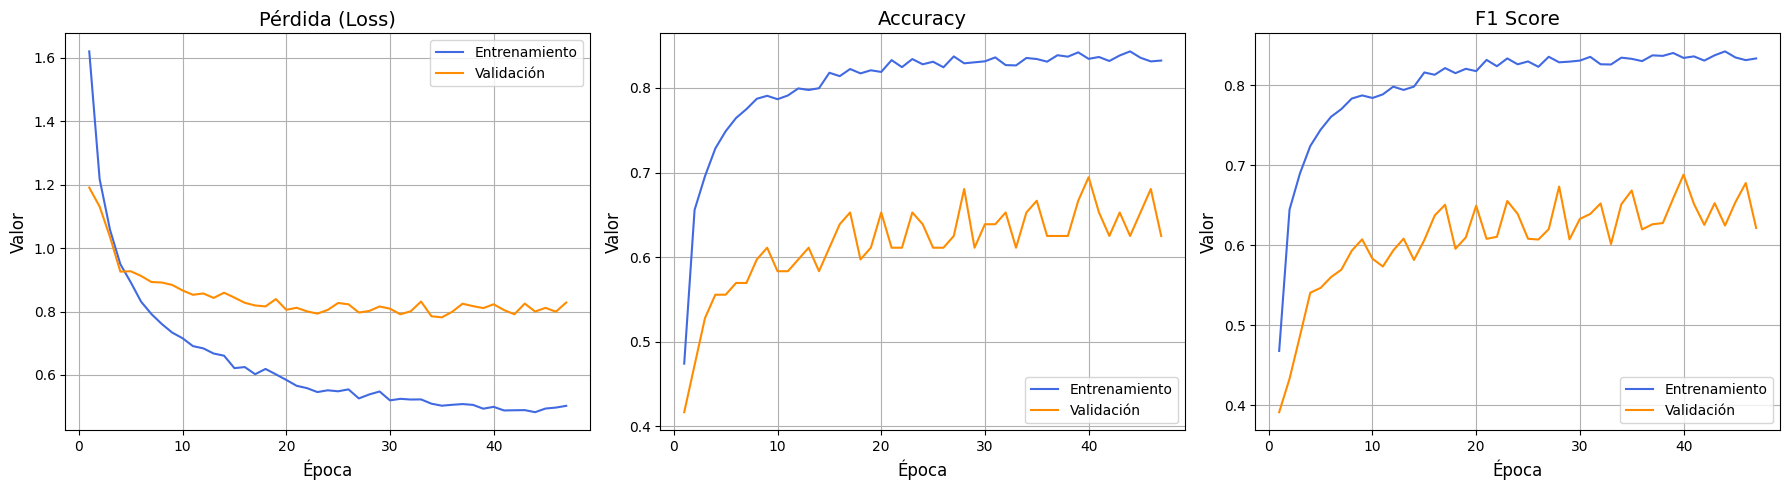

In [13]:
plot_train_results_from_json(json_file='data/inceptionv3_fc_train_results.json')

Resultados guardados en data/inceptionv3_fc_evaluation_results.json


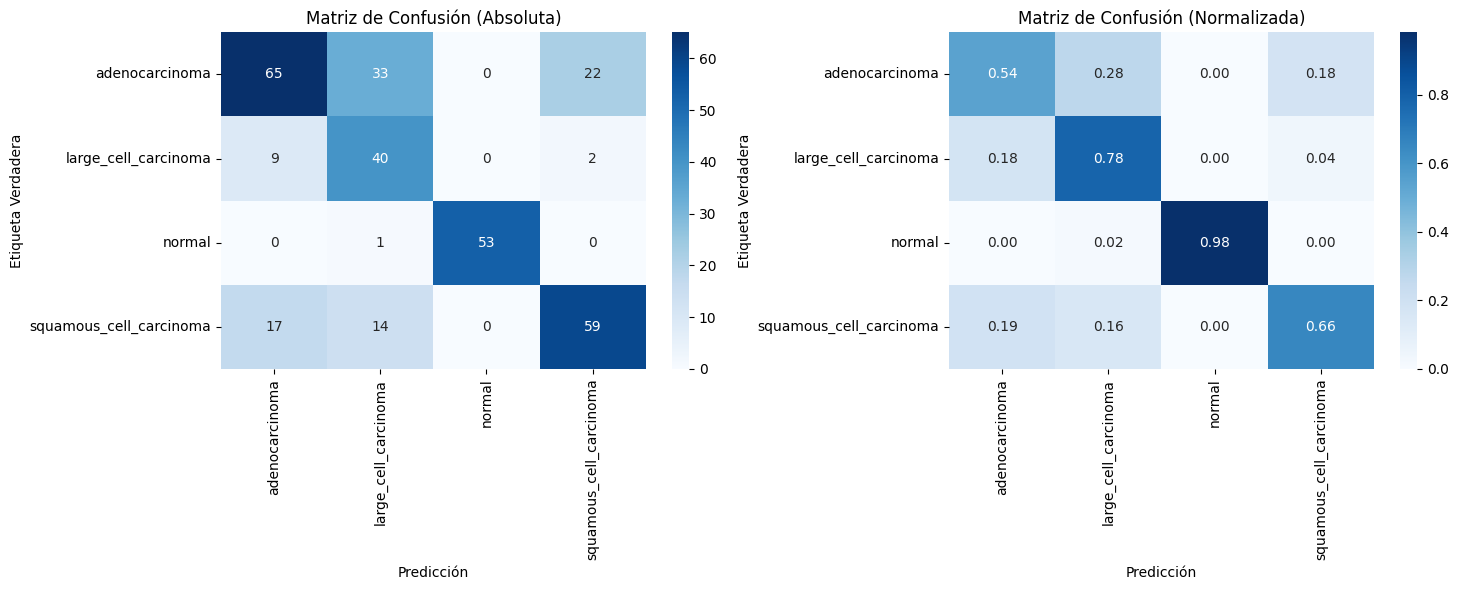

In [14]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/inceptionv3_fc_evaluation_results.json')

In [15]:
model = build_inceptionv3_finetune(num_classes=4)
model = model.to(device)

# Verificación
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")

Entrenando: AuxLogits.conv0.conv.weight
Entrenando: AuxLogits.conv0.bn.weight
Entrenando: AuxLogits.conv0.bn.bias
Entrenando: AuxLogits.conv1.conv.weight
Entrenando: AuxLogits.conv1.bn.weight
Entrenando: AuxLogits.conv1.bn.bias
Entrenando: AuxLogits.fc.weight
Entrenando: AuxLogits.fc.bias
Entrenando: Mixed_7a.branch3x3_1.conv.weight
Entrenando: Mixed_7a.branch3x3_1.bn.weight
Entrenando: Mixed_7a.branch3x3_1.bn.bias
Entrenando: Mixed_7a.branch3x3_2.conv.weight
Entrenando: Mixed_7a.branch3x3_2.bn.weight
Entrenando: Mixed_7a.branch3x3_2.bn.bias
Entrenando: Mixed_7a.branch7x7x3_1.conv.weight
Entrenando: Mixed_7a.branch7x7x3_1.bn.weight
Entrenando: Mixed_7a.branch7x7x3_1.bn.bias
Entrenando: Mixed_7a.branch7x7x3_2.conv.weight
Entrenando: Mixed_7a.branch7x7x3_2.bn.weight
Entrenando: Mixed_7a.branch7x7x3_2.bn.bias
Entrenando: Mixed_7a.branch7x7x3_3.conv.weight
Entrenando: Mixed_7a.branch7x7x3_3.bn.weight
Entrenando: Mixed_7a.branch7x7x3_3.bn.bias
Entrenando: Mixed_7a.branch7x7x3_4.conv.weight


In [16]:
fit(model, train_loader=train_loader, eval_loader=val_loader, epochs=100, model_name='data/inceptionv3_Mixed_7_fc_weights.pth', results_file='data/inceptionv3_Mixed_7_fc_train_results.json') 

val_loss 0.84249 val_acc 0.80556: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 1/100 loss 0.45838 val_loss 0.84249 acc 0.87861 val_acc 0.80556 train_f1 0.87628 val_f1 0.80277
Mejor modelo guardado en la época 1 con val_loss 0.84249
Mejor modelo guardado.


val_loss 0.58003 val_acc 0.83333: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 2/100 loss 0.04968 val_loss 0.58003 acc 0.99097 val_acc 0.83333 train_f1 0.99075 val_f1 0.83241
Mejor modelo guardado en la época 2 con val_loss 0.58003
Mejor modelo guardado.


val_loss 0.31873 val_acc 0.87500: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 3/100 loss 0.01666 val_loss 0.31873 acc 0.99692 val_acc 0.87500 train_f1 0.99700 val_f1 0.87288
Mejor modelo guardado en la época 3 con val_loss 0.31873
Mejor modelo guardado.


val_loss 0.20118 val_acc 0.93056: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 4/100 loss 0.01110 val_loss 0.20118 acc 0.99707 val_acc 0.93056 train_f1 0.99700 val_f1 0.93095
Mejor modelo guardado en la época 4 con val_loss 0.20118
Mejor modelo guardado.


val_loss 0.30781 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 5/100 loss 0.00925 val_loss 0.30781 acc 0.99707 val_acc 0.91667 train_f1 0.99700 val_f1 0.91618


val_loss 0.31706 val_acc 0.93056: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch 6/100 loss 0.01028 val_loss 0.31706 acc 0.99717 val_acc 0.93056 train_f1 0.99725 val_f1 0.93176


val_loss 0.34215 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 7/100 loss 0.01029 val_loss 0.34215 acc 0.99644 val_acc 0.90278 train_f1 0.99650 val_f1 0.90476


val_loss 0.70855 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 8/100 loss 0.00593 val_loss 0.70855 acc 0.99878 val_acc 0.91667 train_f1 0.99875 val_f1 0.91950


val_loss 0.65563 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Epoch 9/100 loss 0.00421 val_loss 0.65563 acc 0.99854 val_acc 0.91667 train_f1 0.99850 val_f1 0.91950


val_loss 0.62761 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 10/100 loss 0.00626 val_loss 0.62761 acc 0.99780 val_acc 0.91667 train_f1 0.99775 val_f1 0.92056


val_loss 0.57622 val_acc 0.93056: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 11/100 loss 0.00819 val_loss 0.57622 acc 0.99619 val_acc 0.93056 train_f1 0.99625 val_f1 0.93328


val_loss 0.71919 val_acc 0.88889: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 12/100 loss 0.00902 val_loss 0.71919 acc 0.99683 val_acc 0.88889 train_f1 0.99675 val_f1 0.89364


val_loss 0.52919 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 13/100 loss 0.01443 val_loss 0.52919 acc 0.99609 val_acc 0.91667 train_f1 0.99600 val_f1 0.91718


val_loss 0.33121 val_acc 0.91667: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 14/100 loss 0.01318 val_loss 0.33121 acc 0.99595 val_acc 0.91667 train_f1 0.99600 val_f1 0.91768


val_loss 0.44081 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 15/100 loss 0.00597 val_loss 0.44081 acc 0.99854 val_acc 0.90278 train_f1 0.99850 val_f1 0.90382


val_loss 0.60935 val_acc 0.90278: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

Epoch 16/100 loss 0.01135 val_loss 0.60935 acc 0.99717 val_acc 0.90278 train_f1 0.99725 val_f1 0.90570
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([0.45837581856176257,
  0.04968268540687859,
  0.0166628647421021,
  0.011102286007371731,
  0.00924519493128173,
  0.010283643438015133,
  0.010292797393049113,
  0.005931833253271179,
  0.004211538122035563,
  0.0062624006932310294,
  0.008190431784896646,
  0.009015077903313795,
  0.014426376474148128,
  0.013178697336115874,
  0.00596628673520172,
  0.011353389563737437],
 [0.8424855470657349,
  0.5800310969352722,
  0.31872695684432983,
  0.20118264853954315,
  0.30781111121177673,
  0.3170585036277771,
  0.34214699268341064,
  0.7085468769073486,
  0.6556342244148254,
  0.6276069283485413,
  0.5762234926223755,
  0.7191941738128662,
  0.5291914343833923,
  0.3312070071697235,
  0.4408125579357147,
  0.6093459129333496],
 [0.87861328125,
  0.990966796875,
  0.996923828125,
  0.9970703125,
  0.9970703125,
  0.99716796875,
  0.996435546875,
  0.998779296875,
  0.99853515625,
  0.997802734375,
  0.99619140625,
  0.996826171875,
  0.99609375,
  0.995947265625,
  0.99853515625,
  0.99

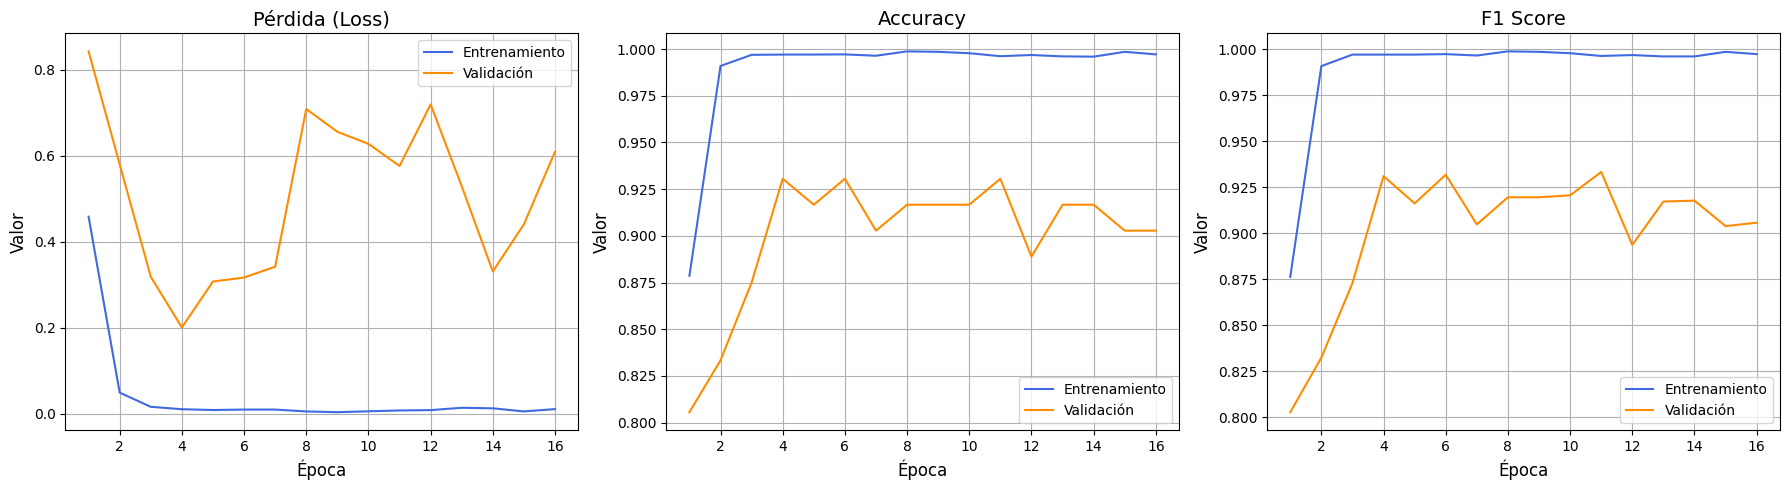

In [17]:
plot_train_results_from_json(json_file='data/inceptionv3_Mixed_7_fc_train_results.json')

Resultados guardados en data/inceptionv3_Mixed_7_fc_evaluation_results.json


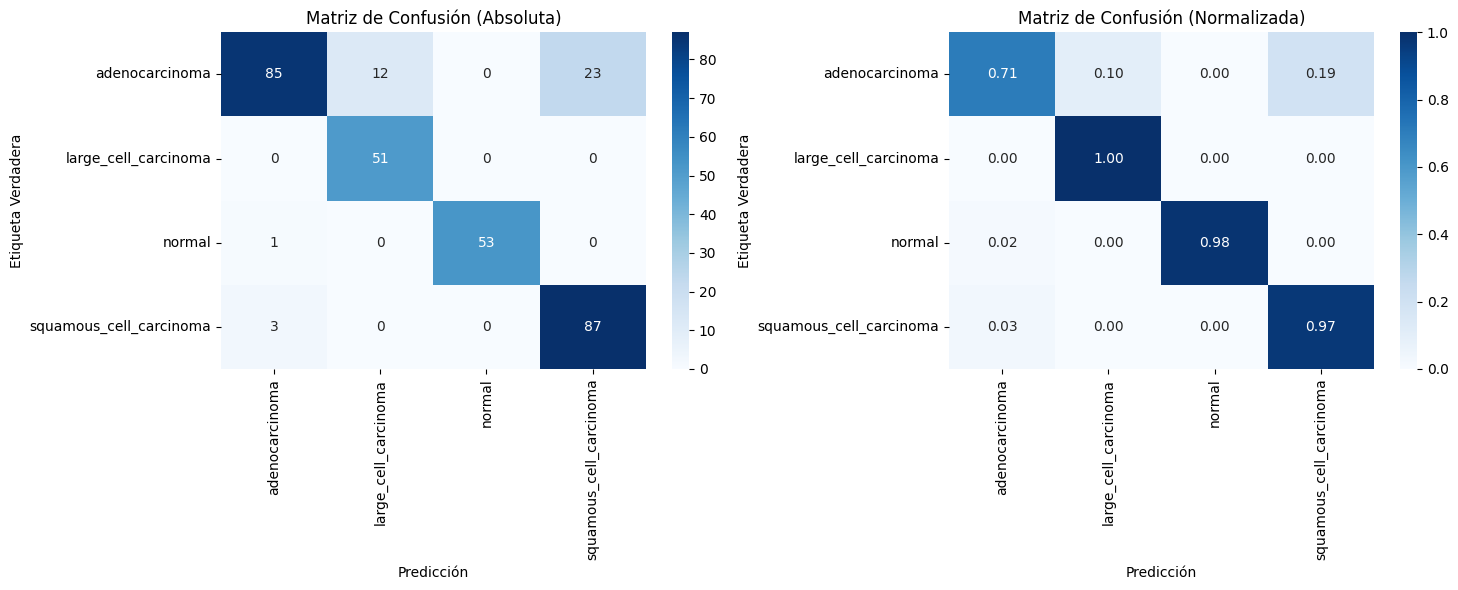

In [18]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/inceptionv3_Mixed_7_fc_evaluation_results.json')